# Fall 2023 Lab Exam Model B

In [108]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Q1

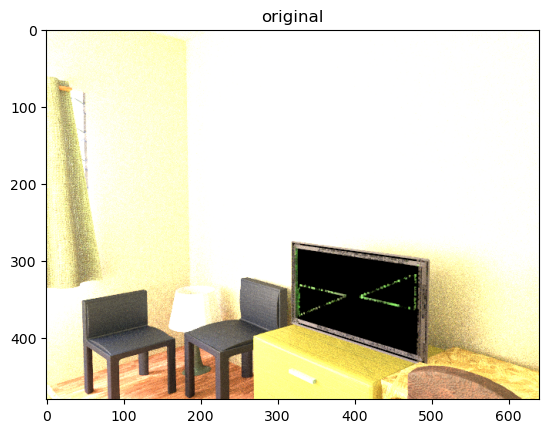

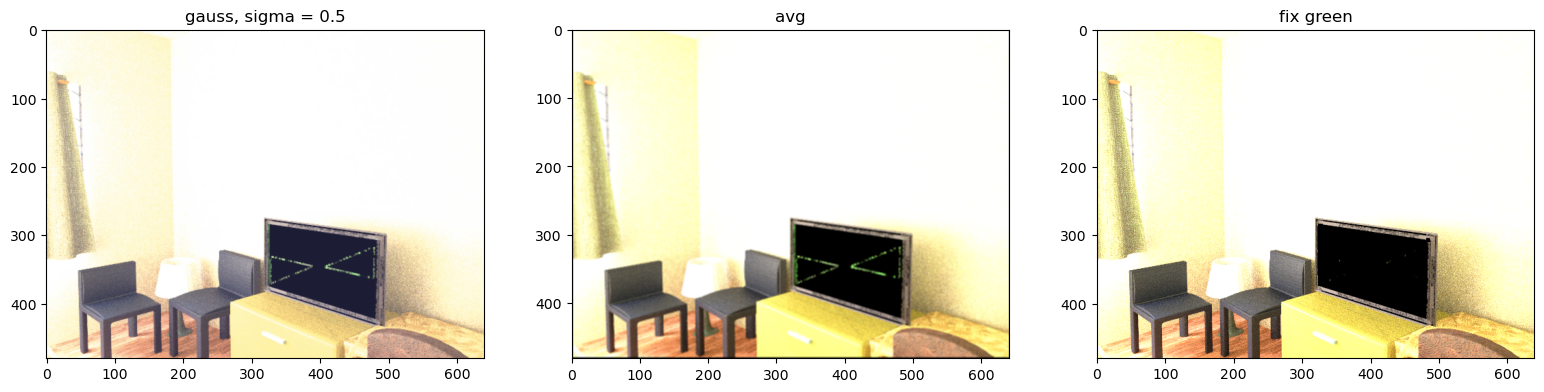

In [21]:
img: np.ndarray = io.imread("Q1.png")
show_images([img], ["original"])
# gauss
sigma = 0.5
img2 = gaussian(img, sigma=sigma)
# avg filter
img_r = img[:, :, 0]
img_g = img[:, :, 1]
img_b = img[:, :, 2]
avg_filter = [[1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9]]
img3_r = convolve2d(img_r, avg_filter)
img3_g = convolve2d(img_g, avg_filter)
img3_b = convolve2d(img_b, avg_filter)
img3 = np.stack((img3_r, img3_g, img3_b), axis=-1).astype("uint8")

# Convert the image to HSV
img_hsv = rgb2hsv(img3[:,:,:3])

# Define green color range in HSV
lower_green = np.array([0.2, 0.3, 0.3])
upper_green = np.array([0.45, 1.0, 1.0])

# Create mask for green regions
green_mask = np.all((img_hsv >= lower_green) & (img_hsv <= upper_green), axis=-1)

# Apply morphological operations
dilated_mask = binary_dilation(green_mask, np.ones((5,5)))

# convert green to black
img_rgb = img[:,:,:3]
for row in range(np.shape(img_rgb)[0]):
    for col in range(np.shape(img_rgb)[1]):
        if(dilated_mask[row, col] == 1):
            img_rgb[row, col]= [0, 0, 0]


show_images([img2, img3, img_rgb], [f"gauss, sigma = {sigma}", "avg", "fix green"])

## Q2

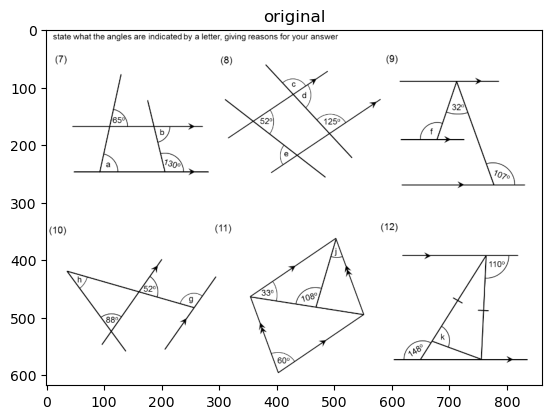

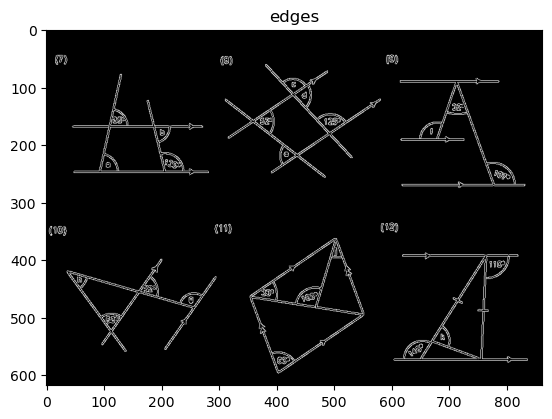

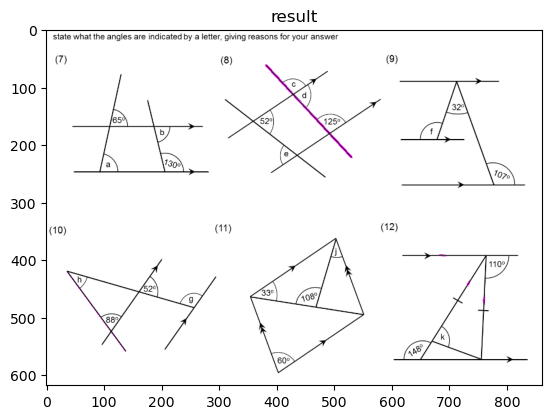

In [4]:
img: np.ndarray = io.imread("Q2.png")


def hough_m_c(img, threshold=100):
    img_gray = (rgb2gray(img[:, :, :3]) * 255).astype("uint8")
    show_images([img_gray], ["original"])
    height, width = np.shape(img_gray)
    # edges
    img_edges = canny(img_gray, sigma=1, low_threshold=50, high_threshold=100)
    img_edges[:30, :] = 0
    show_images([img_edges], ["edges"])
    # hough
    m_start = np.tan(np.deg2rad(40))
    m_end = np.tan(np.deg2rad(60))
    delta_m = 0.01
    m_range = np.linspace(m_start, m_end, 100)
    c_start = -height
    c_end = height
    c_step = 10
    c_range = np.linspace(c_start, c_end, height * 2)
    A = np.zeros((len(m_range), len(c_range)))  # accumulator
    y_idxs, x_idxs = np.nonzero(img_edges)  # get edge coords
    # Fill accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for m_idx, m in enumerate(m_range):
            c = y - m * x  # Calculate the intercept for this slope
            # Find the closest value of c in the c_range
            if c_start <= c <= c_end:
                c_idx = np.argmin(np.abs(c_range - c))
                A[m_idx, c_idx] += 1
    # Accumulator peaks
    lines = []
    for m_idx, c_idx in np.argwhere(A > threshold):
        lines.append((m_range[m_idx], c_range[c_idx]))

    # select lines
    out_img = np.copy(img)
    edge_points = set(zip(y_idxs, x_idxs))
    for m, c in lines:
        x_vals = np.arange(width)
        y_vals = (m * x_vals + c).astype(int)

        # Validate points are within bounds and correspond to actual edge points
        valid_points = [
            (y, x) for y, x in zip(y_vals, x_vals)
            if 0 <= y < height and 0 <= x < width and (y, x) in edge_points
        ]

        # Extract the valid x and y values
        valid_y, valid_x = zip(*valid_points) if valid_points else ([], [])

        # Update the image
        out_img[valid_y, valid_x] = [255, 0, 255, 255]

    return out_img


result = hough_m_c(img, 100)
show_images([result], ["result"])

## Q3

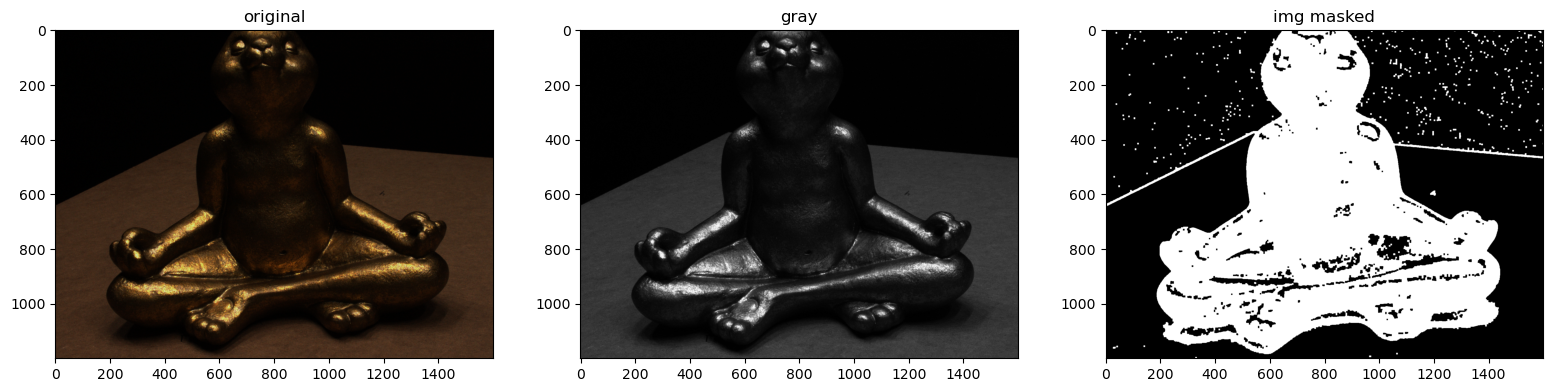

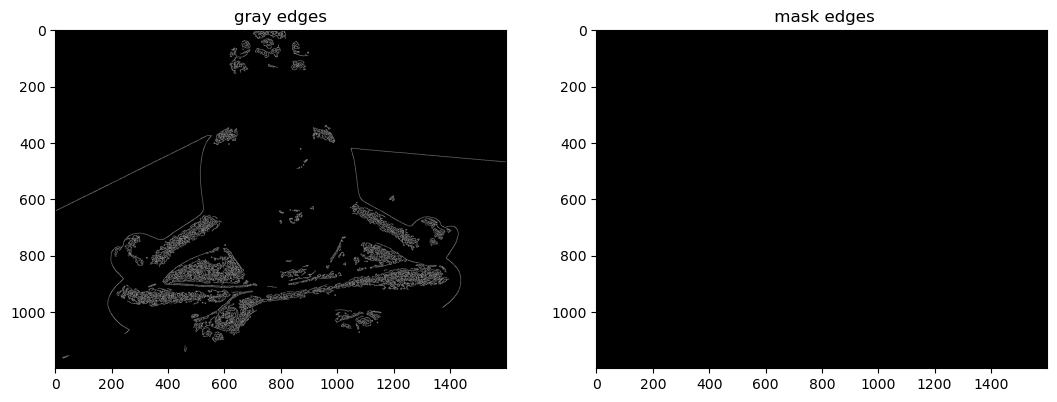

In [91]:
img: np.ndarray = io.imread("Q3.png")
img = img[:, :, :3]
img_gray = (rgb2gray(img[:, :, :3]) * 255).astype("uint8")
img_masked = np.copy(img)
mask = (img_masked[:, :, 0] >= 30) & (img_masked[:, :, 0] <= 100)
mask = mask | (
    (img_masked[:, :, 0] <= 5) & (img_masked[:, :, 1] <= 5) & (img_masked[:, :, 2] <= 5)
)
img_masked[mask] = 0
img_masked[~mask] = 255
img_masked = img_masked[:, :, 0]
img_masked = binary_erosion(binary_dilation(img_masked, np.ones((10,10))), np.ones((5,5)))
show_images([img, img_gray, img_masked], ["original", "gray", "img masked"])
img_gray_edges = canny(img_gray, sigma=1, low_threshold=20, high_threshold=60)
img_mask_edges = canny(img_masked, sigma=1, low_threshold=150, high_threshold=200)

show_images([img_gray_edges, img_mask_edges], ["gray edges"," mask edges"])



30 24
31 30


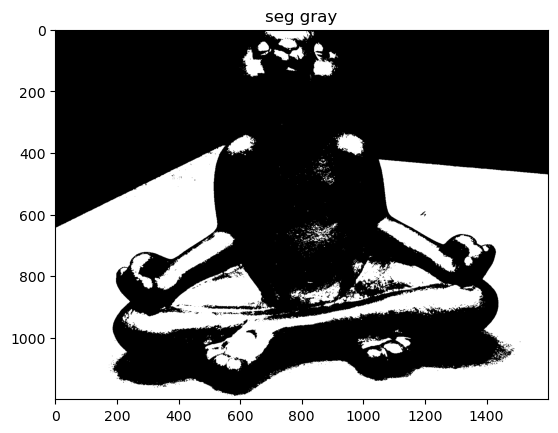

In [67]:
# Seg
def seg(img):
    out_img = np.copy((img).astype("uint8"))
    imgHist = np.zeros(256)
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            imgHist[img[x, y]] += 1
    sum = 0
    for x in range(256):
        sum += imgHist[x] * x
    mean = round(sum / (np.shape(out_img)[0] * np.shape(out_img)[1]))
    sat = False
    while not sat:
        sum1 = 0
        count1 = 0
        sum2 = 0
        count2 = 0
        for x in range(mean):
            sum1 += imgHist[x] * x
            count1 += imgHist[x]
        for x in range(mean, 256):
            sum2 += imgHist[x] * x
            count2 += imgHist[x]
        if count1 != 0:
            mean1 = sum1 / (count1)
        if count2 != 0:
            mean2 = sum2 / (count2)

        if count1 == 0:
            mean1 = mean2
        if count2 == 0:
            mean2 = mean1

        if math.isnan(mean1):
            print("ERRROR mean1", mean1)
            mean1 = mean2
        if math.isnan(mean2):
            print("ERRROR mean2", mean2)
            mean2 = mean1
        mean3 = round((mean1 + mean2) / 2)
        print(mean3, mean)
        if mean3 == mean or abs(mean3 - mean) <= 1:
            sat = True
        mean = mean3

    for x in range(np.shape(out_img)[0]):
        for y in range(np.shape(out_img)[1]):
            if out_img[x, y] < mean:
                out_img[x, y] = 0
            else:
                out_img[x, y] = 1
    return out_img


seg_gray = seg(img_gray)
show_images([seg_gray], ["seg gray"])

15 9
21 15
24 21
25 24
19 12
23 19
24 23
39 40
36 37
1 1
1 1
1 1
1 1
1 1
45 35
52 45
56 52
58 56
60 58
61 60
1 1
11 11
1 1
1 1
18 4
19 18
20 27
20 20
19 11
22 19
22 22
16 12
22 16
32 22
39 32
43 39
46 43
48 46
48 48
25 27
25 25
10 10
25 17
31 25
36 31
40 36
43 40
46 43
48 46
49 48
1 1
8 9
1 1
1 1
1 1
1 1
1 1
31 20
42 31
52 42
59 52
63 59
65 63
66 65
14 7
19 14
20 19
13 13
28 33
28 28
9 3
18 9
19 18
1 1
44 44
34 40
24 34
23 24
34 40
23 34
23 23
43 44
45 45
47 34
59 47
71 59
77 71
80 77
81 80
75 51
88 75
92 88
93 92
9 9
73 66
77 73
79 77
80 79
45 28
55 45
59 55
60 59
44 45
61 42
73 61
79 73
83 79
84 83
45 46
24 23
62 51
69 62
74 69
77 74
79 77
80 79
62 51
68 62
71 68
73 71
74 73
32 28
34 32
35 34
36 34
36 36
17 16
44 35
47 44
51 47
59 51
67 59
71 67
72 71
27 24
29 27
31 29
32 31
59 50
65 59
69 65
71 69
72 71
49 48
44 46
39 44
31 39
31 31
66 52
74 66
78 74
80 78
81 80
40 47
31 40
31 31
36 23
46 36
51 46
53 51
54 53
39 29
46 39
51 46
54 51
56 54
58 56
59 58
34 40
31 34
30 31
32 32
13 13
38

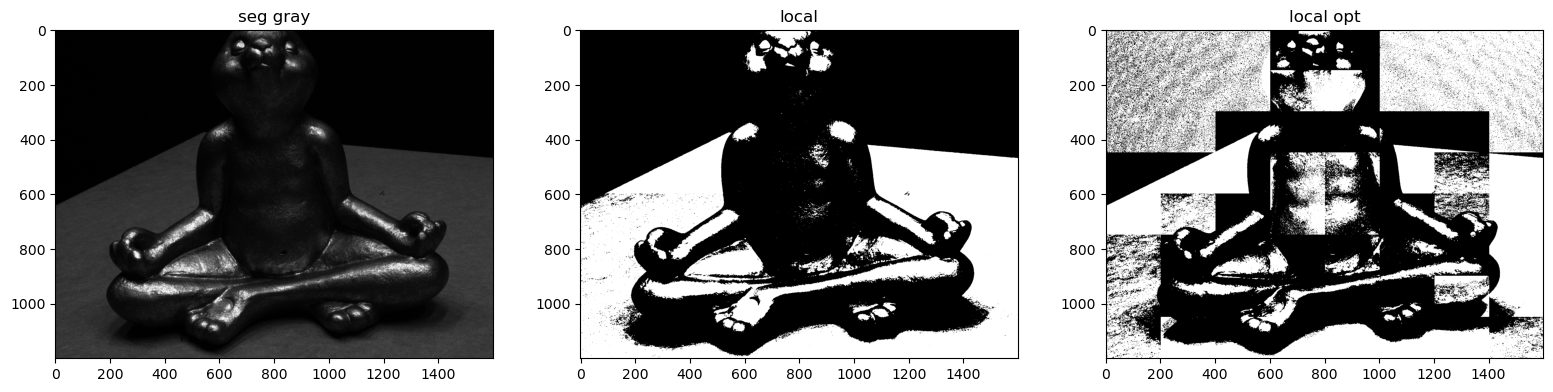

In [81]:
# local thresh
def join_quads(quad, sub_quads):
    img = np.zeros(np.shape(quad))
    x = np.shape(img)[0]
    y = np.shape(img)[1]

    img[0 : round(x / 2), 0 : round(y / 2)] = sub_quads[0]
    img[0 : round(x / 2), round(y / 2) : y] = sub_quads[1]
    img[round(x / 2) : x, 0 : round(y / 2)] = sub_quads[2]
    img[round(x / 2) : x, round(y / 2) : y] = sub_quads[3]

    return img


def local_thres(img):
    img_copy = np.copy((img).astype("uint8"))

    x = np.shape(img_copy)[0]
    y = np.shape(img_copy)[1]

    q1 = img_copy[0 : round(x / 2), 0 : round(y / 2)]
    q2 = img_copy[0 : round(x / 2), round(y / 2) : y]
    q3 = img_copy[round(x / 2) : x, 0 : round(y / 2)]
    q4 = img_copy[round(x / 2) : x, round(y / 2) : y]

    q1_s = seg(np.copy(q1))
    q2_s = seg(np.copy(q2))
    q3_s = seg(np.copy(q3))
    q4_s = seg(np.copy(q4))

    return join_quads(img_copy, [q1_s, q2_s, q3_s, q4_s])


def local_thres_optimized(img, tries = 1):
    img_copy = np.copy((img).astype("uint8"))

    x = np.shape(img_copy)[0]
    y = np.shape(img_copy)[1]

    q1 = img_copy[0 : round(x / 2), 0 : round(y / 2)]
    q2 = img_copy[0 : round(x / 2), round(y / 2) : y]
    q3 = img_copy[round(x / 2) : x, 0 : round(y / 2)]
    q4 = img_copy[round(x / 2) : x, round(y / 2) : y]

    img_optimum = [[]]
    if tries > 0:
        res1 = local_thres_optimized(q1, tries-1)
        res2 = local_thres_optimized(q2, tries-1)
        res3 = local_thres_optimized(q3, tries-1)
        res4 = local_thres_optimized(q4, tries-1)

        img_optimum = join_quads(img_copy, [res1, res2, res3, res4])
        tries -= 1
    else:
        res1 = local_thres(q1)
        res2 = local_thres(q2)
        res3 = local_thres(q3)
        res4 = local_thres(q4)

        img_optimum = join_quads(img_copy, [res1, res2, res3, res4])

    return img_optimum

local = local_thres(img_gray)
local2 = local_thres_optimized(img_gray, 1)
show_images([img_gray, local, local2], ["seg gray", "local", "local opt"])

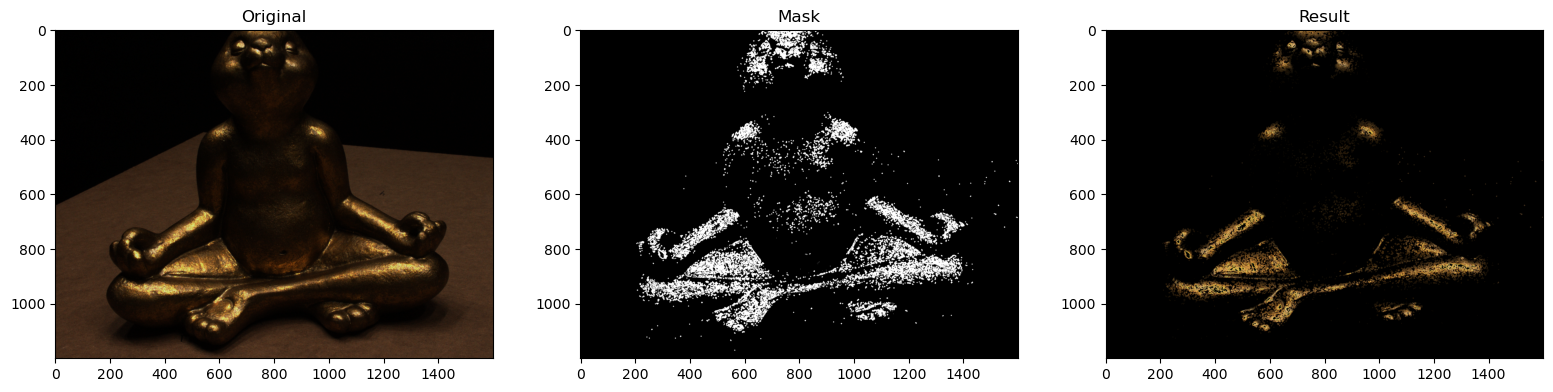

In [121]:
from skimage.color import rgb2hsv, rgb2gray
from skimage import morphology, filters
import numpy as np

# Convert to HSV
img_hsv = rgb2hsv(img)

# Thresholding in the Hue channel for golden color
hue = img_hsv[:, :, 0]
saturation = img_hsv[:, :, 1]
mask = (hue > 0.08) & (hue < 0.15) & (saturation > 0.4)  # Adjust ranges as needed

se = disk(2)
mask = binary_opening(mask, se)
mask = binary_opening(mask, se)
mask = binary_opening(mask, se)

# Use edge detection to refine
edges = sobel(rgb2gray(img))
final_mask = mask | (edges > 0.1)

# Apply mask
result = img.copy()
result[~final_mask] = 0

# Visualize
show_images([img, final_mask, result], ["Original", "Mask", "Result"])


## Q4

98176


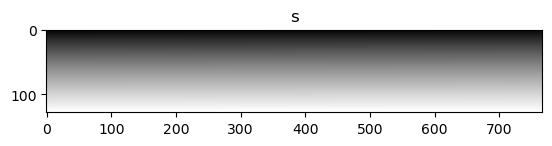

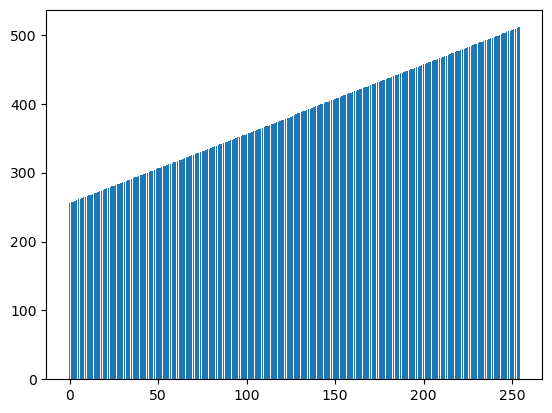

In [6]:
pixel_count = 0
for i in range(256, 512):
    pixel_count += i

row_c = 128
col_c = 767
print(pixel_count)

img = np.zeros((row_c, col_c))
val = 0
num = 0
idx = 0
# hist eqn:
# y = x + 256
for row in range(row_c):
    for col in range(col_c):
        img[row, col] = val
        num += 1
        if num >= 256 + idx:
            val += 1
            idx += 1
            num = 0

show_images([img], ["s"])
count = 0
showHist(img)